# Handle the CIFAR-10 dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/')
%tensorflow_version 1.x
import tensorflow as tf
%matplotlib inline
import pickle
import numpy as np
from os import listdir
from os.path import isfile, join
import os
from sklearn.preprocessing import StandardScaler

# Load the TensorBoard notebook extension
%load_ext tensorboard

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Create a function that will extract the data from the dataset
You can find the dataset here: https://www.cs.utoronto.ca/~kriz/cifar-10-python.tar.gz

When you download the dataset you will get a bunch of pickled files <br>
Inside `cifar-10-batches-py`folder you will find <br>
1. data_batch_x files <br>
2. test_batch 

The data_batch_x files are the batched training data splited in x parts (in our case in 5 parts of 10000 samples each). The test_batch file contains 10000 samples for testing.

### The structure
All files has the same structure: <br>
1. data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
2. labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

There is also another file called batches.meta where it describes the classes

In [0]:
############### Download CIFAR-10 data and save it to google drive
import requests  
file_url = "https://www.cs.utoronto.ca/~kriz/cifar-10-python.tar.gz"
    
r = requests.get(file_url, stream = True)  
  
with open("/content/drive/My Drive/DeepNN_HandsOn/cifar-10-python.tar.gz", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

In [0]:
### unzip the file
!gunzip "/content/drive/My Drive/DeepNN_HandsOn/cifar-10-python.tar.gz"

In [0]:
##### Untar the file
!tar -xvf "/content/drive/My Drive/DeepNN_HandsOn/cifar-10-python.tar"

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
# Function to unpickle the dataset
def unpickle_all_data(directory):
    
    # Initialize the variables
    train = dict()
    test = dict()
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    # Iterate through all files that we want, train and test
    # Train is separated into batches
    for filename in listdir(directory):
        if isfile(join(directory, filename)):
            
            # The train data
            if 'data_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Opent the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')

                if 'data' not in train:
                    train['data'] = data[b'data']
                    train['labels'] = np.array(data[b'labels'])
                else:
                    train['data'] = np.concatenate((train['data'], data[b'data']))
                    train['labels'] = np.concatenate((train['labels'], data[b'labels']))
            # The test data
            elif 'test_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Open the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')
                
                test['data'] = data[b'data']
                test['labels'] = data[b'labels']
    
    # Manipulate the data to the proper format
    for image in train['data']:
        train_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    train_y = [label for label in train['labels']]
    
    for image in test['data']:
        test_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    test_y = [label for label in test['labels']]
    
    # Transform the data to np array format
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    return (train_x, train_y), (test_x, test_y)

## Using the function

Returns four variables
1. x_train := A 3D numpy array with the images in a format (32, 32, 3) a 32x32 image with 3 dimmesions for colors RGB
2. y_train := A 1D numpy with the numbered labels for each sample stom x_train
3. x_test := same as x_train
4. y_test := same as y_train

In [0]:
(x_train, y_train), (x_test, y_test) = unpickle_all_data(os.getcwd() + '/cifar-10-batches-py/')

Handing file: data_batch_3
Handing file: data_batch_1
Handing file: data_batch_5
Handing file: test_batch
Handing file: data_batch_2
Handing file: data_batch_4


(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)
6


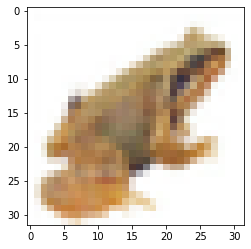

In [0]:
import matplotlib.pyplot as plt
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
######### display image
plt.imshow(x_train[3])
print(y_train[3])

## Preprocess the data
1. The data must be in a float32 represenation
2. The data should be normalized, here I chose [0,1] normalization
3. The labels are one-hot encoded

In [0]:
from keras.utils import np_utils

# Transofrm them to a float32 type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the input 
train_mean = np.mean(x_train,axis=(0,1,2,3))
train_std = np.std(x_train,axis=(0,1,2,3))
test_mean = np.mean(x_test,axis=(0,1,2,3))
test_std = np.std(x_test,axis=(0,1,2,3))
x_train = (x_train-train_mean)/(train_std+1e-7)
x_test = (x_test-test_mean)/(test_std+1e-7)
#x_train /= 255
#x_test /= 255

# One-hot Encoding
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


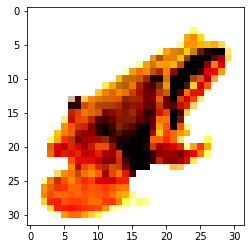

In [0]:
######### display image
plt.imshow(x_train[3])
#print(x_train[3])

## Building the model
1. The input data for the model is each image sample 32x32x3
2. Convolve the image into 3x3 squares with padding same (https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t) and Pooling with 2x2. Add a dropout of 0.2 to avoid early overfitting
3. Same situation for the next two layers for 64 input size, and 128 input size
4. Finally, add a Dense(fully connected) layer for the output

You can try different layouts to improve the accuracy

In [0]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Augment the data
From one sample, extract multiple versions

For example, rotate the image, shift, flip etc

In [0]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


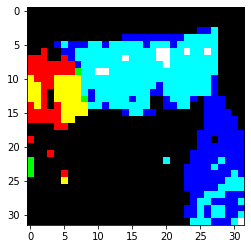

In [0]:
#view images
gen = datagen.flow(x_train, y_train, batch_size=64)
x,y = gen.next()
image = x[0].astype('uint')
print(y[0])
plt.imshow(image)

## Compiling the model

In [0]:
# Compile the model
import datetime
from keras.callbacks import TensorBoard
batch_size = 64

opt_rms = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt_rms, 
              metrics=['accuracy'])
logdir = os.path.join("/content/drive/My Drive/DeepNN_HandsOn/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [0]:
############## initiate tensorboard
#!kill 443
%tensorboard --logdir "/content/drive/My Drive/DeepNN_HandsOn/logs"

Reusing TensorBoard on port 6006 (pid 475), started 0:13:09 ago. (Use '!kill 475' to kill it.)

## Training the algorithm
I would suggest more than 100 epochs

In [0]:
epochs = 5
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks= [tensorboard_callback])#[TensorBoardColabCallback(tbc)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











Epoch 1/5
781/781 [==============================] - 41s 52ms/step - loss: 1.5730 - acc: 0.4279 - val_loss: 1.1969 - val_acc: 0.5757

Epoch 2/5
781/781 [==============================] - 35s 45ms/step - loss: 1.2070 - acc: 0.5738 - val_loss: 0.9467 - val_acc: 0.6606
Epoch 3/5
781/781 [==============================] - 35s 45ms/step - loss: 1.0692 - acc: 0.6279 - val_loss: 0.8877 - val_acc: 0.6874
Epoch 4/5
781/781 [==============================] - 35s 45ms/step - loss: 1.0011 - acc: 0.6513 - val_loss: 0.9626 - val_acc: 0.6696
Epoch 5/5
781/781 [==============================] - 35s 45ms/step - loss: 0.9563 - acc: 0.6692 - val_loss: 0.8665 - val_acc: 0.7049


In [0]:
out= model.predict(x_train[0:4])
out[3]

array([1.0872292e-06, 1.0250151e-05, 1.9979252e-02, 1.2615286e-01,
       5.9632465e-02, 3.6577124e-02, 7.5343728e-01, 4.1993009e-03,
       3.2080740e-07, 1.0025548e-05], dtype=float32)